<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Homework 03 - Diffusion Maps</div><br>
    <div style="font-size: large">Authors</div>Luis Antonio Ortega Andrés<br>Antonio Coín Castro</div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used.

In [3]:
import numpy as np
import math
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve

from mpl_toolkits.mplot3d import Axes3D
Axes3D

matplotlib.rc('figure', figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Introduction

This practical assignment consists in implementing the manifold learning method **Diffusion Maps**, following the *scikit-learn* template for manifold learning methods.

We will design two main functions: one for training the algorithm, obtaining the affinity matrix and the embedded coordinates, and a second one for extending these coordinates for new patterns.

# Requirements

The objective of this assignment is to complete the class DM sketched below, which should contain at least the following methods.

`__init__(self, sigma, n_components, step=1, alpha=1)`

* This is the construction method for the class, with the following parameters:
    * `sigma`: Kernel parameter for the Gaussian kernel.
    * `n_components`: dimension of the embedding.
    * `step`: step in the Markov Chain.
    * `alpha`: density influence. It should a value in `[0,1]`.
* This method should only store the parameters in fields of the class, to be used when needed.

`fit(self, X, y=None)`

* This is the training method, the one that performs the Diffusion Maps algorithm. 

* This method should store the affinity matrix and also the eigenvectors to computed the transformation.

`fit_transform(self, X, y=None)`

* This method returns the embedding coordinates for the training data.
* It should also store the affinity matrix and the coordinates needed to compute the transformation (for example over new, unseen patterns).

`transform(self, X)`

* This method will obtain approximated coordinates for new, unseen data points. 
* It uses for this purpose the Nyström Formula.

## Some recommendations

* It should allow to fix all the DM possibilities (different steps, density normalization...). To allow a change in the kernel function could be also a nice idea.
* Implement all the auxiliary functions that you may need, for example, for deciding the best parameter values in each case.
* It could be a nice idea to offer a deterministic output, that do not depend on the sign of the eigenvectors.

# Implementation

<div class="qst">

* Complete the `DM` class below, satisfying the described requirements.

</div>

**TODO**

- Permitir elegir percentil con 'perc' y parámetro extra. Por defecto p=0.5.
- Comentar y organizar el código (reproducir estructura de [sklearn](https://github.com/scikit-learn/scikit-learn/blob/95119c13af77c76e150b753485c662b7c52a41a2/sklearn/manifold/_spectral_embedding.py)).
- Responder a las preguntas del final.

In [290]:
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import (
    rbf_kernel, laplacian_kernel, euclidean_distances
)
from sklearn.exceptions import NotFittedError


class DiffusionMaps(BaseEstimator):
    """Diffusion Maps algorithm for manifold learning [1].

    We use the data to define a weighted graph based on  
    kernel similarity, then define a random walk over the graph, 
    and finally use the transition probabilities to find an 
    embedding to a lower-dimensional space. 

    [1] Coifman, R. R., & Lafon, S. (2006). Diffusion maps. 
        Applied and computational harmonic analysis, 21(1), 5-30.
    """

    def __init__(
        self,
        n_components=2,
        step=1,
        alpha=1.0,
        affinity='rbf',
        sigma='median'   # 'median', 'maximum', 'auto', float
    ):
        self.n_components = n_components
        self.step = step
        self.alpha = alpha
        self.affinity = affinity
        self.sigma = sigma

    def _deterministic_vector_sign_flip(self, u):
        """
        Modify the sign of vectors for reproducibility.
        Flips the sign of elements of all the vectors 
        (rows of u) such that the absolute maximum element 
        of each vector is positive.

        Available in sklearn/utils/exmath.py

        Parameters
        ----------
        u : ndarray
            Array with vectors as its rows.

        Returns
        -------
        u_flipped : ndarray with same shape as u
            Array with the sign flipped vectors as its rows.
        """
        max_abs_rows = np.argmax(np.abs(u), axis=1)
        signs = np.sign(u[range(u.shape[0]), max_abs_rows])
        u *= signs[:, np.newaxis]
        return u

    def _choose_sigma(self):
        """
        Handles the initialization of sigma. For example,
        if sigma is "median", computes the median of the
        pairwise distances.

        Raises an error if sigma is not "median", "maximum",
        "auto" or a numerical value.
        """
        if self.sigma == 'median':
            self.sigma_ = np.median(euclidean_distances(self._data))
        elif self.sigma == 'maximum':
            self.sigma_ = np.max(euclidean_distances(self._data))
        elif self.sigma == 'auto':
            self.sigma_ = np.sqrt(self._data.shape[1]/2.)
        elif isinstance(self.sigma, (int, float)):
            if self.sigma <= 0:
                raise ValueError(
                    ("sigma must be positive. Got %s") % self.sigma)
            self.sigma_ = self.sigma
        else:
            raise ValueError(("%s is not a valid sigma parameter. "
                              "Expected 'median', 'maximum', 'auto' "
                              "or a float.") % self.sigma)

    def _choose_n_components(self):
        """
        Handles the initialization of the number of components, i.e, the
        dimensionality of the embedding. 

        In case a float value is used in the declaration,
        ```
        n\_components = \argmin_{l} |\lambda_l| <= \delta |\lambda_1|^T
        ```
        """
        if isinstance(self.n_components, int):
            self.n_components_ = self.n_components
        elif isinstance(self.n_components, float):
            self.n_components_ = np.argmin(
                np.abs(self.eigvals)**self.step >
                self.n_components*np.abs(self.eigvals[1])**self.step)
        else:
            raise ValueError(("%s is not a valid n_components parameter. \
                              Expected int of float.") % self.n_components)

    def _get_affinity_matrix(self, X, Y=None):
        """
        Computes the affinity_matrix, i.e, kernel matrix 
        of the given inputs.

        If self.affinity is a callable, it should
        have the signature 'affinity(X, Y=None)', with
        the understanding that when Y=None the affinity
        between X and itself is calculated.

        Parameters
        ----------
        X : ndarray
            Array with vectors as its columns.
        Y : ndarray
            Array with vectors as its columns. Optional
            If none K(X,X) is computed
        Returns
        -------
        affinity_matrix : ndarray
            Array with the kernel applied K(X,Y)
        """
        if self.affinity == 'rbf':
            return rbf_kernel(X, Y, gamma=1/(2*self.sigma_**2))
        if self.affinity == 'laplacian':
            return laplacian_kernel(X, Y, gamma=1/(2*self.sigma_**2))
        if self.affinity == 'precomputed':
            return X

        # affinity is a function on its own
        return self.affinity(X, Y)

    def _diagonalize(self, M):
        """
        Computes the eigenvalues and eigenvectors 
        of the given matrix M. 

        Parameters
        ----------
        M : ndarray
            Matrix to diagonalize.
        Returns
        -------
        eigen_vals : ndarray
            Array with the eigenvalues
        eigen_vecs : ndarray
            Array with the eigenvectors
        """

        # Get eigenvalues and left eigenvectors
        eigvals, eigvecs = np.linalg.eig(M)

        # Check that complex part is negligible and ignore it
        if np.iscomplexobj(eigvals):
            threshold_imaginary_part = 1e-6
            max_imaginary_part = np.max(
                np.abs(np.imag(eigvals))
            )

            if max_imaginary_part > threshold_imaginary_part:
                warnings.warn(
                    "Maximum imaginary part is {}".format(
                        max_imaginary_part)
                )

            eigvals = np.real(eigvals)
            eigvecs = np.real(eigvecs)

        # Sort in descending order
        idx = eigvals.argsort()[::-1]

        return eigvals[idx], eigvecs[:, idx]

    def fit(self, X, y=None):
        """Compute the embedding vectors for data X.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored

        Returns
        -------
        self : returns an instance of self.
        """
        self._data = X
        self._choose_sigma()

        if isinstance(self.affinity, str):
            if self.affinity not in {"rbf", "laplacian", "precomputed"}:
                raise ValueError(("%s is not a valid kernel. Expected "
                                  "'precomputed', 'rbf', 'laplacian' "
                                  "or a callable.") % self.affinity)
        elif not callable(self.affinity):
            raise ValueError(("'affinity' is expected to be a kernel "
                              "name or a callable. Got: %s") % self.affinity)

        # Compute affinity matrix
        self.affinity_matrix_ = self._get_affinity_matrix(X)

        # Degree diagonal matrix
        degree_v = (np.sum(self.affinity_matrix_,
                           axis=1) + 1e-9)**(-self.alpha)
        Dv = np.diag(degree_v)

        # Density normalization
        K_alpha = Dv@self.affinity_matrix_@Dv
        D_alpha = np.sum(K_alpha, axis=1).reshape(-1, 1) + 1e-9

        # Transition probability matrix
        P = K_alpha/D_alpha

        # Eigendecomposition of P
        self._eigvals, self._eigvecs = self._diagonalize(P)
        self._choose_n_components()
        self._eigvals = self._eigvals[1:self.n_components_ + 1]
        self._eigvecs = self._eigvecs[:, 1:self.n_components_ + 1]
        self._eigvecs = self._deterministic_vector_sign_flip(self._eigvecs.T).T

        # Embedding
        self.embedding_ = (self._eigvals**self.step)*self._eigvecs

        return self

    def diffusion_distance(self):
        if not hasattr(self, "_data"):
            raise NotFittedError("The object was not fitted.")

        return np.array([
            [np.sum(
                self._eigvals**(2*self.step)*(self._eigvecs[i, :] - self._eigvecs[j, :])**2)
             for i in range(len(self._data))] for j in range(len(self._data))])

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        return self.embedding_

    def transform(self, X):
        """Transform X.
        This is implemented using the Nyström formula.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features).

        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        if np.array_equal(self._data, X):
            return self.embedding_

        K = self._get_affinity_matrix(X, self._data)
        Dv_left = np.diag((np.sum(K, axis=1) + 1e-9)**(-self.alpha))
        Dv_right = np.diag((np.sum(K, axis=0) + 1e-9)**(-self.alpha))
        K_alpha = Dv_left@K@Dv_right
        D_alpha = np.sum(K_alpha, axis=1).reshape(-1, 1) + 1e-9
        P = K_alpha/D_alpha

        return (1./self._eigvals)*(P@self._eigvecs)

## Check distances

In [291]:
dm = DiffusionMaps(n_components=2, sigma=1.0)
X_red = dm.fit_transform(X)
dm.diffusion_distance()

array([[0.        , 0.00096353, 0.00197246, ..., 0.00044029, 0.00232214,
        0.00104366],
       [0.00096353, 0.        , 0.00106852, ..., 0.00021104, 0.0006854 ,
        0.00060366],
       [0.00197246, 0.00106852, 0.        , ..., 0.00180806, 0.00021758,
        0.00014795],
       ...,
       [0.00044029, 0.00021104, 0.00180806, ..., 0.        , 0.00155494,
        0.00100451],
       [0.00232214, 0.0006854 , 0.00021758, ..., 0.00155494, 0.        ,
        0.00037216],
       [0.00104366, 0.00060366, 0.00014795, ..., 0.00100451, 0.00037216,
        0.        ]])

In [292]:
euclidean_distances(X_red)**2

array([[0.        , 0.00096353, 0.00197246, ..., 0.00044029, 0.00232214,
        0.00104366],
       [0.00096353, 0.        , 0.00106852, ..., 0.00021104, 0.0006854 ,
        0.00060366],
       [0.00197246, 0.00106852, 0.        , ..., 0.00180806, 0.00021758,
        0.00014795],
       ...,
       [0.00044029, 0.00021104, 0.00180806, ..., 0.        , 0.00155494,
        0.00100451],
       [0.00232214, 0.0006854 , 0.00021758, ..., 0.00155494, 0.        ,
        0.00037216],
       [0.00104366, 0.00060366, 0.00014795, ..., 0.00100451, 0.00037216,
        0.        ]])

## Spectral embedding comparison

We are doing a small test where we verify that our implemented algorithm raises the same results with $step = \alpha = 0$ than using spectral embedding from Sklearn.

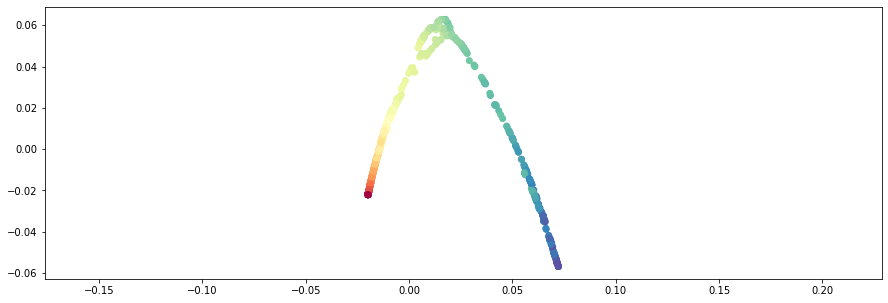

In [293]:
N = 1000
X, color = make_swiss_roll(N, random_state=seed)

dm = DiffusionMaps(n_components=2, sigma=1.0, step=0, alpha=0)
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

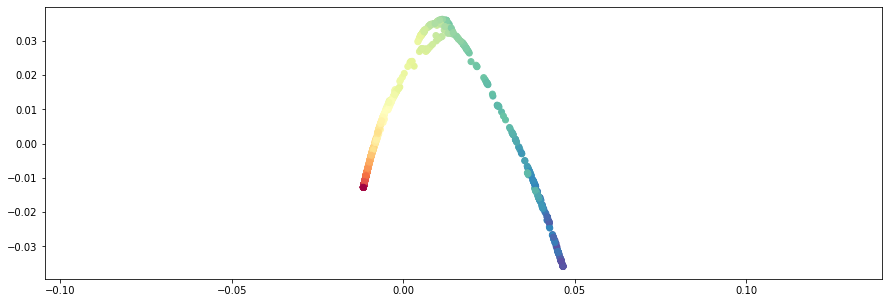

In [294]:
from sklearn.manifold import SpectralEmbedding

se = SpectralEmbedding(affinity='rbf', gamma=0.5)
X_red = se.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

# Experiments with DM

<div class="qst">

* Obtain some good embedded coordinates for the three training datasets specified below.
    
* Extend its coordinates for the new points.
    
</div>

## Dataset 1: two blobs

In [261]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

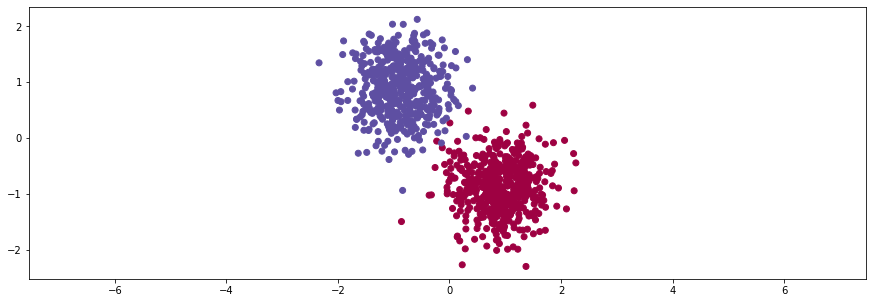

In [279]:
N = 1000

X, y = make_blobs(n_samples=N, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed)
X = scaler.fit_transform(X)

plt.scatter(X[:,0], X[:,1], c=y, cmap=my_cmap)
plt.axis('equal')
plt.show()

N_new=100
X_new, y_new = make_blobs(n_samples=N_new, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed+1)
X_new = scaler.transform(X_new)

Fristly, we use the optimal parameters we have found so far.

In [280]:
dm = DiffusionMaps(n_components=2, sigma='median')
X_red = dm.fit_transform(X)
print("Sigma:", dm.sigma_)

Sigma: 9.84111956098517


We may plot the embedding of the "training set".

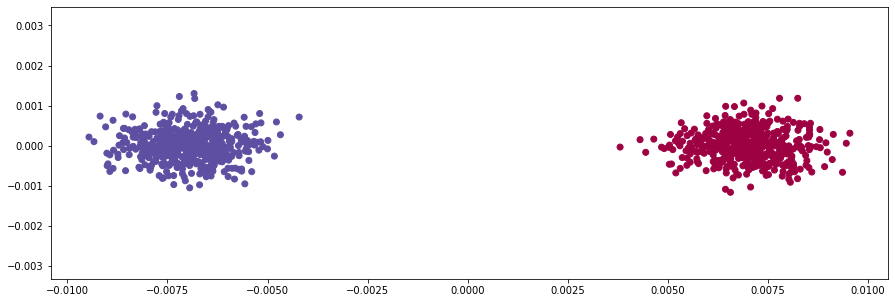

In [281]:
plt.scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)
plt.axis('equal')
plt.show()

Lastly, we may are transforming the "testing" dataset.

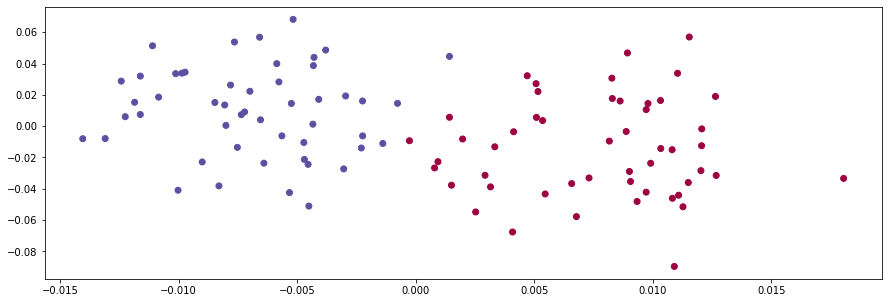

In [282]:
X_red_n = dm.transform(X_new)
plt.scatter(X_red_n[:, 0], X_red_n[:, 1], c=y_new, cmap=my_cmap)
plt.show()

## Dataset 2: the swiss roll

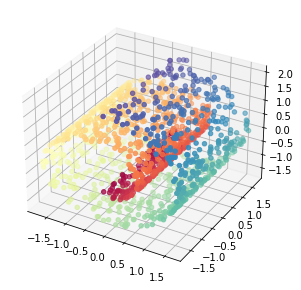

In [295]:
N=1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new=100
X_new, color_new = make_swiss_roll(n_samples=N_new, random_state=seed+1)
X_new = scaler.transform(X_new)

In [296]:
dm = DiffusionMaps(n_components=2, sigma=0.15, step=1)
X_red = dm.fit_transform(X)
print("Sigma:", dm.sigma_)

Sigma: 0.15


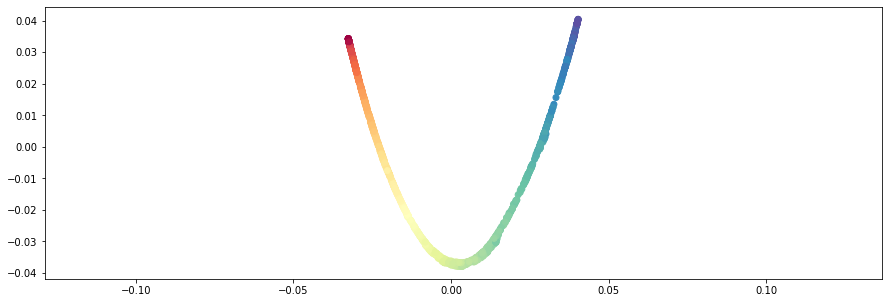

In [297]:
plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

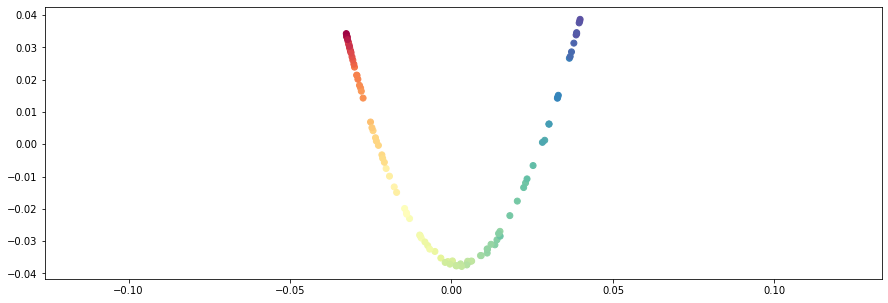

In [298]:
X_red_n = dm.transform(X_new)
plt.scatter(X_red_n[:, 0], X_red_n[:, 1], c=color_new, cmap=my_cmap)
plt.axis('equal')
plt.show()

## Dataset 3: the S curve

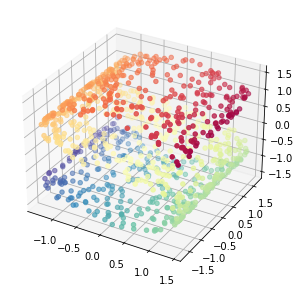

In [299]:
N = 1000
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed+1)
X_new = scaler.transform(X_new)

In [359]:
dm = DiffusionMaps(n_components=2, sigma=0.55)
X_red = dm.fit_transform(X)
print("Sigma:", dm.sigma_)

Sigma: 0.55


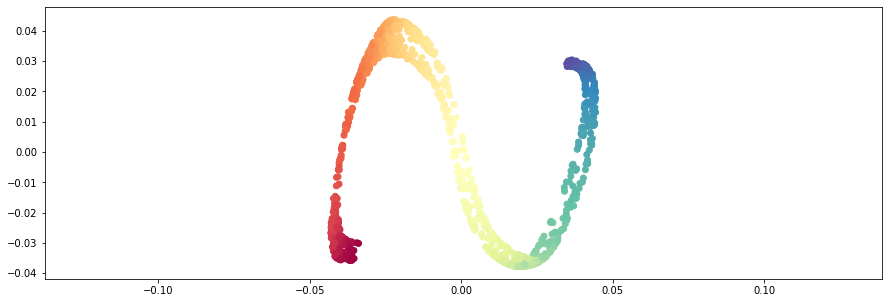

In [360]:
plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

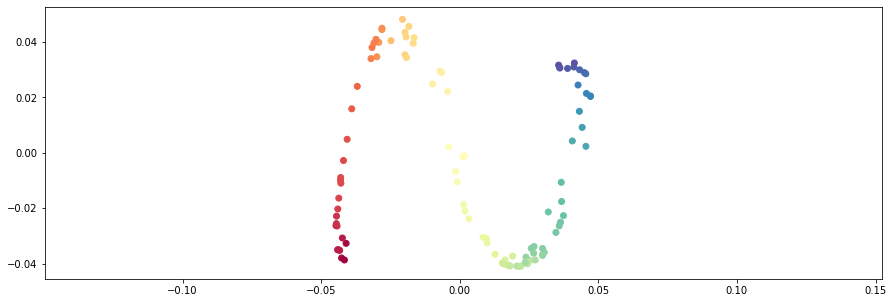

In [361]:
X_red_n = dm.transform(X_new)
plt.scatter(X_red_n[:, 0], X_red_n[:, 1], c=color_new, cmap=my_cmap)
plt.axis('equal')
plt.show()

<div class="qst">

* Do you consider the embedding obtained is good for the previous datasets? Is it the expected one? Why?
    
* How sensible is the method to its hyper-parameters? Specify the best values that you have found and the technique employed for it.
    * Check how much influence the sample density (you can vary N for each dataset).
    * Check what happens if the number of steps `steps` grows.
    
* What do you think are the main advantage and disadvantage of this method?
    
</div>